In [1]:
from google.colab import drive
drive.mount('/gdrive')

%cd '/gdrive/My Drive/ADM/Colab'

Mounted at /gdrive
/gdrive/My Drive/ADM/Colab


In [0]:
from data_collection import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


import tensorflow as tf
import pickle
import os

In [0]:
#---------------------------------Dataset and Preprocessing---------------------------------------

def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

    
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity,df):
    data = df[df['activity'] == activity][['la_x', 'la_y', 'la_z']][:200] #[:13530]
#    data = df[['la_x', 'la_x', 'la_x']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(0.5, 1))
        
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)


def segment_signal(df,N_TIME_STEPS,step):
        
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        ax = df["la_x"].values[i:i+N_TIME_STEPS]
        ay = df["la_y"].values[i:i+N_TIME_STEPS]
        az = df["la_z"].values[i:i+N_TIME_STEPS]
        fox = df["gx"].values[i:i+N_TIME_STEPS]
        foy = df["gy"].values[i:i+N_TIME_STEPS]
        foz = df["gz"].values[i:i+N_TIME_STEPS]
        label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
#        segments.append([ax,ay,az])
        segments.append([ax,ay,az,fox,foy,foz])
        labels.append(label)
    return segments, labels

def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)
    

#-----------------------------------------Evaluation-------------------------------
def printCM(predictions ,y_test):    
    LABELS = [ name for name in os.listdir(filepath) if os.path.isdir(os.path.join(filepath, name)) ]
    
    max_test = np.argmax(y_test, axis=1)
    max_predictions = np.argmax(predictions, axis=1)
    confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show();
    print(classification_report(max_test, max_predictions))
    
def print_acc_loss():
    plt.figure(figsize=(12, 8))
    
    plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
    plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")
    
    plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
    plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")
    
    plt.title("Training session's progress over iterations")
    plt.legend(loc='upper right', shadow=True)
    plt.ylabel('Training Progress (Loss or Accuracy values)')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    
    plt.show()

    
def generate_random_hyperparams(lr_min, lr_max, bt_min, bt_max,hu_min, hu_max, ep_min, ep_max, l2_min, l2_max):
    '''generate random learning rate and keep probability'''
    # random search through log space for learning rate
    random_learning_rate = np.random.uniform(lr_min, lr_max)
    random_learning_rate = random_learning_rate * 10**(-3)
    
    
    random_l2loss_rate = np.random.uniform(l2_min, l2_max)
    random_l2loss_rate = random_l2loss_rate * 10**(-3)
    
    random_batch_size = np.random.uniform(bt_min, bt_max)
    hidden_units = np.random.uniform(hu_min, hu_max)
    epochs = np.random.uniform(ep_min, ep_max)
    return random_learning_rate,int(random_batch_size) ,int(hidden_units), int(epochs), random_l2loss_rate


def get_segment(N_TIME_STEPS, step):
    segments, labels = segment_signal(dataset, N_TIME_STEPS, step)
    np.array(segments).shape

    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS , N_FEATURES)
    labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
    
    X_train, X_test, y_train, y_test = train_test_split(
            reshaped_segments, labels, test_size=0.2, random_state=0)
    
    return X_train, X_test, y_train, y_test

def tesorboard_params(N_TIME_STEPS):
    log = LOGS_DIR + str(N_TIME_STEPS)
    trainPath = log + "/train/" 
    testPath = log + "/test/" 
    validationPath = log + "/validation/"
    
    if not os.path.exists(trainPath):
        os.makedirs(trainPath)
    if not os.path.exists(testPath):
        os.makedirs(testPath)
    if not os.path.exists(testPath):
        os.makedirs(testPath)
    
    train_writer = tf.summary.FileWriter(trainPath)
    test_writer = tf.summary.FileWriter(testPath)
    validation_writer = tf.summary.FileWriter(validationPath)
    
    return train_writer, test_writer, validation_writer

In [0]:
# Our model contains 2 fully-connected and 2 LSTM layers (stacked on each other) with 64 units each:
def model(inputs, batch_size, N_HIDDEN_UNITS, N_TIME_STEPS):
    weights = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    
    bias = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }

    with tf.name_scope('inputs'):
        X = tf.transpose(inputs, [1, 0, 2])
        X = tf.reshape(X, [-1, N_FEATURES])
    
    with tf.name_scope('hidden'):
        hidden = tf.nn.relu(tf.matmul(X, weights['hidden']) + bias['hidden'])  
        hidden = tf.split(hidden, N_TIME_STEPS, 0)
    tf.summary.histogram("hidden", hidden)  


    # Stack 2 LSTM layers
    lstm = [tf.nn.rnn_cell.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for num in range(2)]
    lstm = tf.nn.rnn_cell.MultiRNNCell(lstm)
    
    ### Run the data through the RNN layers
    with tf.name_scope("RNN_forward"):
    # Run each sequence step through the RNN with tf.nn.dynamic_rnn 
        outputs, _ = tf.nn.static_rnn(lstm, hidden, dtype=tf.float32)          

    # Get output for the last time step
    final_layer = outputs[-1]
    tf.summary.histogram("final_layer", final_layer)  
#    tf.summary.histogram('final_layer', final_layer)

    return tf.matmul(final_layer, weights['output']) + bias['output']

In [0]:
#----------------------------- Wrapper function for Hyperparameter Tuning -------------------------------------------
def run_model(N_TIME_STEPS,BATCH_SIZE, LEARNING_RATE,N_EPOCHS, N_HIDDEN_UNITS,L2_LOSS, log_type, early_stopping_step, save_modal):
    
    print("\n---------------------------Run_model for window size : " + str(N_TIME_STEPS) + ', step size : ' + str(N_TIME_STEPS/2) + "------------------")
    
    print("\nCreating Segments ... ")
    X_train, X_test, y_train, y_test = get_segment(N_TIME_STEPS, int(N_TIME_STEPS/2))
    
    train_writer, test_writer, validation_writer = tesorboard_params(N_TIME_STEPS)
    
    # Early Stopping Params
    best_acc = 0
    stopping_step =0;
    
    # Building Model
    tf.reset_default_graph()
    
    print("Building Modal ... ")
    # Placeholders for our model
    X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
    Y = tf.placeholder(tf.float32, [None, N_CLASSES])
    
    # Note that we named the input tensor, that will be useful when using the model from Android. Creating the model:
    pred_Y = model(X,BATCH_SIZE, N_HIDDEN_UNITS, N_TIME_STEPS)
    tf.summary.histogram("matmul", pred_Y) 
    
    pred_softmax = tf.nn.softmax(pred_Y, name="y_")
    tf.summary.histogram("pred_softmax", pred_softmax)  
    
    
#    # Again, we must properly name the tensor from which we will obtain predictions. We will use L2 regularization and that must be noted in our loss op:
#    L2_LOSS = 0.0015
    
    l2 = L2_LOSS * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2
    tf.summary.scalar('loss', loss)
    
    
    #optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)
    with tf.name_scope('train'):
      optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)
    
    
    with tf.name_scope('accuracy'):
      with tf.name_scope('correct_prediction'):
        correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
      with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    tf.summary.scalar('accuracy', accuracy)
    
    saver = tf.train.Saver()
    
    history = dict(train_loss=[], 
                         train_acc=[], 
                         test_loss=[], 
                         test_acc=[])
    
    sess=tf.InteractiveSession()
    merged = tf.summary.merge_all()
    sess.run(tf.global_variables_initializer())
    
    train_count = len(X_train)
    
    # Training
    for i in range(1, N_EPOCHS + 1):
        for start, end in zip(range(0, train_count, BATCH_SIZE),
                              range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
            sess.run([optimizer], feed_dict={X: X_train[start:end],
                                           Y: y_train[start:end]})
    
        _, acc_train, loss_train,summary = sess.run([pred_softmax, accuracy, loss,merged], feed_dict={
                                                X: X_train, Y: y_train})
            
        history['train_loss'].append(loss_train)
        history['train_acc'].append(acc_train)
        
#        train_writer.add_summary(summary, i)
        if (acc_train > best_acc):
            stopping_step = 0
            best_acc = acc_train
            print("Epoch: {} acc:{}".format(i,acc_train))
        else:
            stopping_step += 1
            print("Epoch: {} acc:{}".format(i,acc_train))
        if stopping_step >= early_stopping_step:
            print("Early stopping is trigger at step: {} acc:{}".format(i,acc_train))
            break;
    
    
        if i != 1 and i % 10 != 0:
            continue
    
        _, acc_test, loss_test, summary = sess.run([pred_softmax, accuracy, loss,merged], feed_dict={
                                                X: X_test, Y: y_test})
#        test_writer.add_summary(summary, i)
        
        history['test_loss'].append(loss_test)
        history['test_acc'].append(acc_test)
        print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test} | train accuracy: {acc_train} loss :{loss_train}\n')
        
         
    predictions , acc_final, loss_final, summary = sess.run([pred_softmax, accuracy, loss, merged], feed_dict={X: X_test, Y: y_test})
    printCM(predictions, y_test)
    
    print(f'\nfinal results: accuracy: {acc_final} loss: {loss_final}\n')    
    modal_summary = { 'history' : history, 'predictions' : predictions, 'true_labels' :  y_test, 'sess' : sess, 'score' : { 'acc' : acc_final, 'loss' : loss_final, }, 'saver' : saver }
    
    if save_modal == False:
        sess.close()
    return modal_summary

In [0]:
#----------------------------------------- Setting Initial Values -------------------------------
#Setting up initial values
random_seed = 611
plt.style.use('ggplot')

# Read form filepath (`track` data) and save csv to parent of filepath
filepath = 'dataset'
#dataset = read_dataset(filepath)

# Read form saved csv
dataset = pd.read_csv("colab_dataset.csv")

N_FEATURES = 6
N_CLASSES = 6
performance_records = {}
LOGS_DIR = './logs/'

#----------------------------- Tuned Parameters -------------------------------------------
LEARNING_RATE =  0.001527643691277451
BATCH_SIZE =  326
N_HIDDEN_UNITS =  63
N_EPOCHS =  10
L2_LOSS =  0.0031853637328882623

---------- Model : 0 ---------------

learning_rate: 0.0010731285088124939, batch_size: 327, hidden_units: 62, epochs: 16, l2_loss: 0.004009304341056284 


---------------------------Run_model for window size : 50, step size : 25.0------------------

Creating Segments ... 
Building Modal ... 
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

S

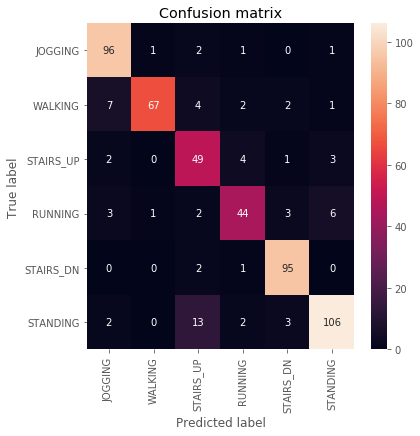

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       101
           1       0.97      0.81      0.88        83
           2       0.68      0.83      0.75        59
           3       0.81      0.75      0.78        59
           4       0.91      0.97      0.94        98
           5       0.91      0.84      0.87       126

    accuracy                           0.87       526
   macro avg       0.86      0.86      0.86       526
weighted avg       0.88      0.87      0.87       526


final results: accuracy: 0.8688212633132935 loss: 2.491133451461792


---------------------------Run_model for window size : 80, step size : 40.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.3422256112098694
epoch: 1 test accuracy: 0.31610941886901855 loss: 4.2401018142700195 | train accuracy: 0.3422256112098694 loss :4.1175689697265625

Epoch: 2 acc:0.519817054271698
Epoch: 3 acc:0.5076219439506531
Epoch: 4 acc:0.651676

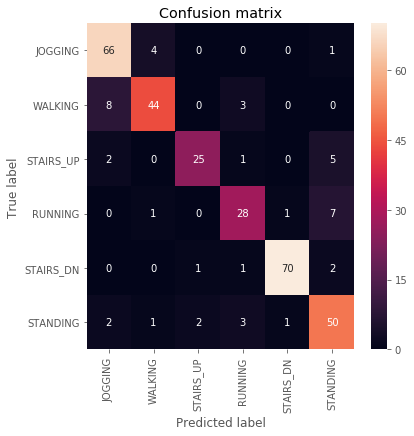

              precision    recall  f1-score   support

           0       0.85      0.93      0.89        71
           1       0.88      0.80      0.84        55
           2       0.89      0.76      0.82        33
           3       0.78      0.76      0.77        37
           4       0.97      0.95      0.96        74
           5       0.77      0.85      0.81        59

    accuracy                           0.86       329
   macro avg       0.86      0.84      0.85       329
weighted avg       0.86      0.86      0.86       329


final results: accuracy: 0.8601823449134827 loss: 2.540560007095337


---------------------------Run_model for window size : 120, step size : 60.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.20685714483261108
epoch: 1 test accuracy: 0.26940637826919556 loss: 4.218079566955566 | train accuracy: 0.20685714483261108 loss :4.319869518280029

Epoch: 2 acc:0.37599998712539673
Epoch: 3 acc:0.40685713291168213
Epoch: 4 acc:0.50

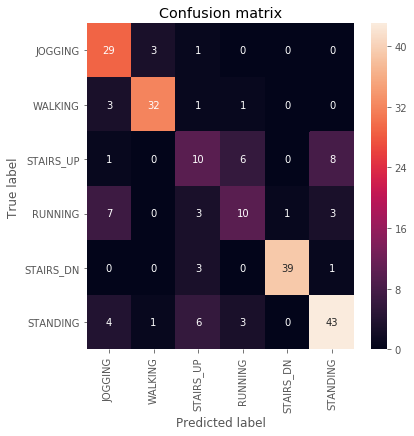

              precision    recall  f1-score   support

           0       0.66      0.88      0.75        33
           1       0.89      0.86      0.88        37
           2       0.42      0.40      0.41        25
           3       0.50      0.42      0.45        24
           4       0.97      0.91      0.94        43
           5       0.78      0.75      0.77        57

    accuracy                           0.74       219
   macro avg       0.70      0.70      0.70       219
weighted avg       0.75      0.74      0.74       219


final results: accuracy: 0.7442922592163086 loss: 3.1367805004119873


---------------------------Run_model for window size : 160, step size : 80.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.3643292784690857
epoch: 1 test accuracy: 0.4085365831851959 loss: 4.308809280395508 | train accuracy: 0.3643292784690857 loss :4.188632965087891

Epoch: 2 acc:0.44054877758026123
Epoch: 3 acc:0.5243902206420898
Epoch: 4 acc:0.55182

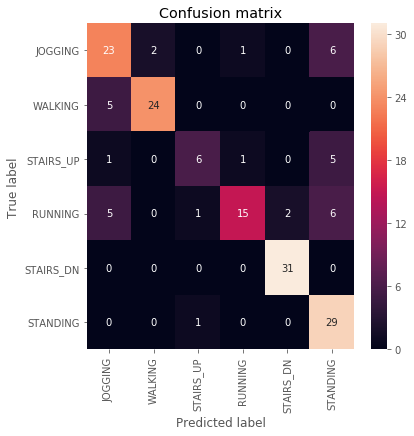

              precision    recall  f1-score   support

           0       0.68      0.72      0.70        32
           1       0.92      0.83      0.87        29
           2       0.75      0.46      0.57        13
           3       0.88      0.52      0.65        29
           4       0.94      1.00      0.97        31
           5       0.63      0.97      0.76        30

    accuracy                           0.78       164
   macro avg       0.80      0.75      0.75       164
weighted avg       0.80      0.78      0.77       164


final results: accuracy: 0.7804877758026123 loss: 2.8747355937957764


---------------------------Run_model for window size : 200, step size : 100.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.19465649127960205
epoch: 1 test accuracy: 0.1666666716337204 loss: 4.264294624328613 | train accuracy: 0.19465649127960205 loss :4.238115310668945

Epoch: 2 acc:0.3320610821247101
Epoch: 3 acc:0.3263358771800995
Epoch: 4 acc:0.353

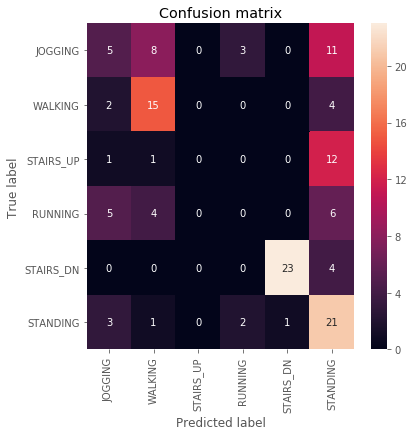

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.31      0.19      0.23        27
           1       0.52      0.71      0.60        21
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        15
           4       0.96      0.85      0.90        27
           5       0.36      0.75      0.49        28

    accuracy                           0.48       132
   macro avg       0.36      0.42      0.37       132
weighted avg       0.42      0.48      0.43       132


final results: accuracy: 0.4848484992980957 loss: 3.6749682426452637

---------- Model : 1 ---------------

learning_rate: 0.0025271497924369904, batch_size: 413, hidden_units: 64, epochs: 43, l2_loss: 0.0021748704621434678 


---------------------------Run_model for window size : 50, step size : 25.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.425035685300827
epoch: 1 test accuracy: 0.4391635060310364 loss: 2.887249946

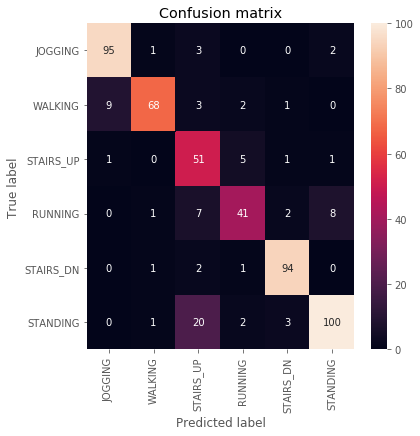

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       101
           1       0.94      0.82      0.88        83
           2       0.59      0.86      0.70        59
           3       0.80      0.69      0.75        59
           4       0.93      0.96      0.94        98
           5       0.90      0.79      0.84       126

    accuracy                           0.85       526
   macro avg       0.85      0.85      0.84       526
weighted avg       0.87      0.85      0.86       526


final results: accuracy: 0.8536121845245361 loss: 1.594112753868103


---------------------------Run_model for window size : 80, step size : 40.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.2507621943950653
epoch: 1 test accuracy: 0.29483282566070557 loss: 3.1633553504943848 | train accuracy: 0.2507621943950653 loss :3.232651472091675

Epoch: 2 acc:0.46341463923454285
Epoch: 3 acc:0.5541158318519592
Epoch: 4 acc:0.62576

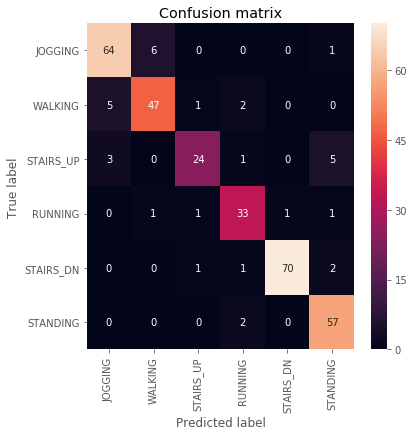

              precision    recall  f1-score   support

           0       0.89      0.90      0.90        71
           1       0.87      0.85      0.86        55
           2       0.89      0.73      0.80        33
           3       0.85      0.89      0.87        37
           4       0.99      0.95      0.97        74
           5       0.86      0.97      0.91        59

    accuracy                           0.90       329
   macro avg       0.89      0.88      0.88       329
weighted avg       0.90      0.90      0.90       329


final results: accuracy: 0.8966565132141113 loss: 1.491635799407959


---------------------------Run_model for window size : 120, step size : 60.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.31771427392959595
epoch: 1 test accuracy: 0.3287671208381653 loss: 3.526754856109619 | train accuracy: 0.31771427392959595 loss :3.4565072059631348

Epoch: 2 acc:0.36000001430511475
Epoch: 3 acc:0.43314287066459656
Epoch: 4 acc:0.45

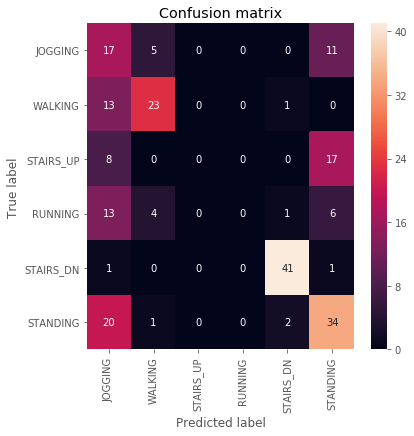

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.24      0.52      0.32        33
           1       0.70      0.62      0.66        37
           2       0.00      0.00      0.00        25
           3       0.00      0.00      0.00        24
           4       0.91      0.95      0.93        43
           5       0.49      0.60      0.54        57

    accuracy                           0.53       219
   macro avg       0.39      0.45      0.41       219
weighted avg       0.46      0.53      0.48       219


final results: accuracy: 0.5251141786575317 loss: 2.3234550952911377


---------------------------Run_model for window size : 160, step size : 80.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.20579268038272858
epoch: 1 test accuracy: 0.18902438879013062 loss: 4.474022388458252 | train accuracy: 0.20579268038272858 loss :4.60994815826416

Epoch: 2 acc:0.18902438879013062
Epoch: 3 acc:0.27743902802467346
Epoch: 4 acc:0.36

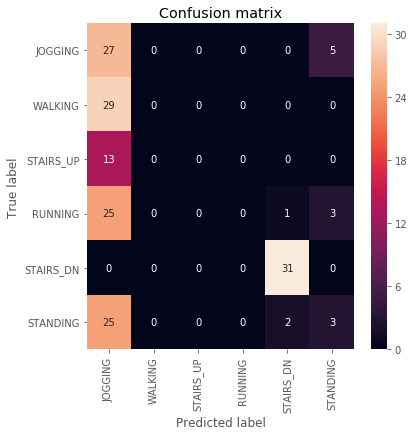

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.23      0.84      0.36        32
           1       0.00      0.00      0.00        29
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        29
           4       0.91      1.00      0.95        31
           5       0.27      0.10      0.15        30

    accuracy                           0.37       164
   macro avg       0.24      0.32      0.24       164
weighted avg       0.27      0.37      0.28       164


final results: accuracy: 0.37195122241973877 loss: 2.7698612213134766


---------------------------Run_model for window size : 200, step size : 100.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.31679388880729675
epoch: 1 test accuracy: 0.3636363744735718 loss: 3.6941261291503906 | train accuracy: 0.31679388880729675 loss :3.8131794929504395

Epoch: 2 acc:0.3377862572669983
Epoch: 3 acc:0.20801526308059692
Epoch: 4 acc:0

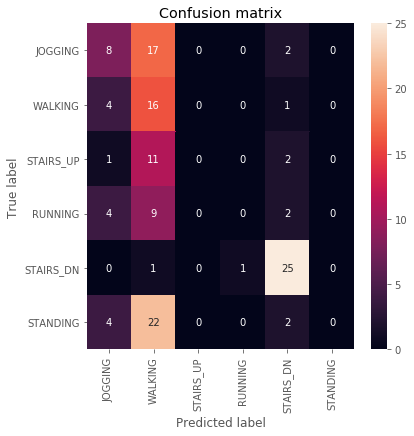

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.38      0.30      0.33        27
           1       0.21      0.76      0.33        21
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        15
           4       0.74      0.93      0.82        27
           5       0.00      0.00      0.00        28

    accuracy                           0.37       132
   macro avg       0.22      0.33      0.25       132
weighted avg       0.26      0.37      0.29       132


final results: accuracy: 0.3712121248245239 loss: 2.91987943649292

---------- Model : 2 ---------------

learning_rate: 0.001543737149553835, batch_size: 387, hidden_units: 61, epochs: 31, l2_loss: 0.003650209631024652 


---------------------------Run_model for window size : 50, step size : 25.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.41075679659843445
epoch: 1 test accuracy: 0.3821292817592621 loss: 3.62521362304

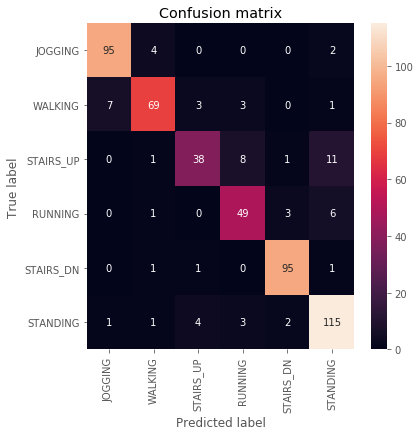

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       101
           1       0.90      0.83      0.86        83
           2       0.83      0.64      0.72        59
           3       0.78      0.83      0.80        59
           4       0.94      0.97      0.95        98
           5       0.85      0.91      0.88       126

    accuracy                           0.88       526
   macro avg       0.87      0.85      0.86       526
weighted avg       0.88      0.88      0.87       526


final results: accuracy: 0.8764258623123169 loss: 2.2201027870178223


---------------------------Run_model for window size : 80, step size : 40.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.30868902802467346
epoch: 1 test accuracy: 0.3191489279270172 loss: 3.7290611267089844 | train accuracy: 0.30868902802467346 loss :3.7694101333618164

Epoch: 2 acc:0.4702743887901306
Epoch: 3 acc:0.5106707215309143
Epoch: 4 acc:0.583

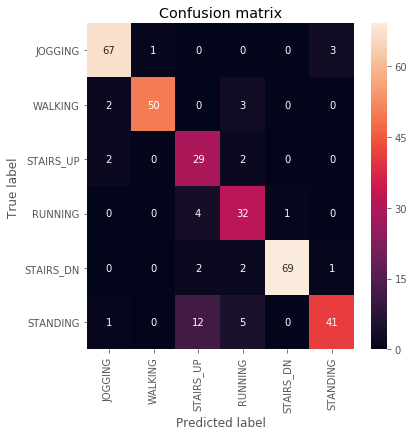

              precision    recall  f1-score   support

           0       0.93      0.94      0.94        71
           1       0.98      0.91      0.94        55
           2       0.62      0.88      0.73        33
           3       0.73      0.86      0.79        37
           4       0.99      0.93      0.96        74
           5       0.91      0.69      0.79        59

    accuracy                           0.88       329
   macro avg       0.86      0.87      0.86       329
weighted avg       0.89      0.88      0.88       329


final results: accuracy: 0.8753799200057983 loss: 2.1862430572509766


---------------------------Run_model for window size : 120, step size : 60.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.32342857122421265
epoch: 1 test accuracy: 0.36986300349235535 loss: 3.9025511741638184 | train accuracy: 0.32342857122421265 loss :3.929931640625

Epoch: 2 acc:0.44685715436935425
Epoch: 3 acc:0.5120000243186951
Epoch: 4 acc:0.4457

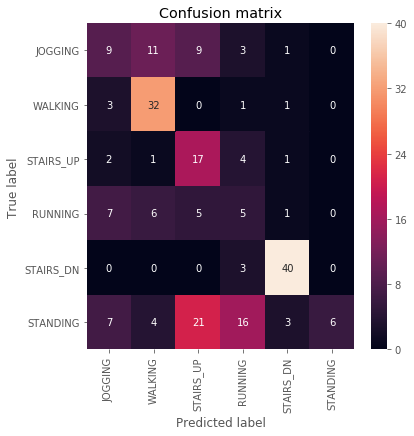

              precision    recall  f1-score   support

           0       0.32      0.27      0.30        33
           1       0.59      0.86      0.70        37
           2       0.33      0.68      0.44        25
           3       0.16      0.21      0.18        24
           4       0.85      0.93      0.89        43
           5       1.00      0.11      0.19        57

    accuracy                           0.50       219
   macro avg       0.54      0.51      0.45       219
weighted avg       0.63      0.50      0.46       219


final results: accuracy: 0.49771690368652344 loss: 3.38663911819458


---------------------------Run_model for window size : 160, step size : 80.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.2073170691728592
epoch: 1 test accuracy: 0.2073170691728592 loss: 4.674806594848633 | train accuracy: 0.2073170691728592 loss :4.523820877075195

Epoch: 2 acc:0.27439025044441223
Epoch: 3 acc:0.3018292784690857
Epoch: 4 acc:0.277439

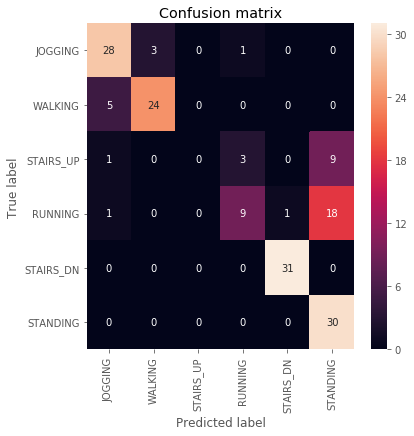

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.80      0.88      0.84        32
           1       0.89      0.83      0.86        29
           2       0.00      0.00      0.00        13
           3       0.69      0.31      0.43        29
           4       0.97      1.00      0.98        31
           5       0.53      1.00      0.69        30

    accuracy                           0.74       164
   macro avg       0.65      0.67      0.63       164
weighted avg       0.72      0.74      0.70       164


final results: accuracy: 0.7439024448394775 loss: 2.9071109294891357


---------------------------Run_model for window size : 200, step size : 100.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.23664122819900513
epoch: 1 test accuracy: 0.25757575035095215 loss: 3.862358570098877 | train accuracy: 0.23664122819900513 loss :3.889120101928711

Epoch: 2 acc:0.4122137427330017
Epoch: 3 acc:0.37404578924179077
Epoch: 4 acc:0.3

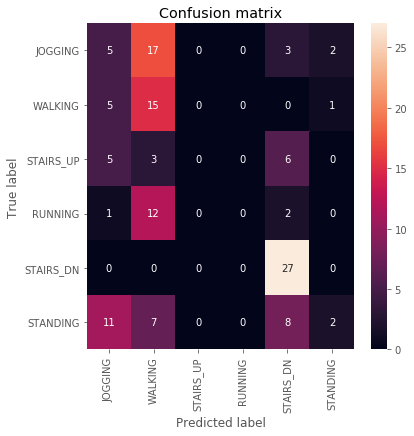

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.19      0.19      0.19        27
           1       0.28      0.71      0.40        21
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        15
           4       0.59      1.00      0.74        27
           5       0.40      0.07      0.12        28

    accuracy                           0.37       132
   macro avg       0.24      0.33      0.24       132
weighted avg       0.29      0.37      0.28       132


final results: accuracy: 0.3712121248245239 loss: 3.500272750854492

---------- Model : 3 ---------------

learning_rate: 0.0011750556181198664, batch_size: 400, hidden_units: 78, epochs: 30, l2_loss: 0.0019752672583797544 


---------------------------Run_model for window size : 50, step size : 25.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.5268919467926025
epoch: 1 test accuracy: 0.5399239659309387 loss: 2.854496479

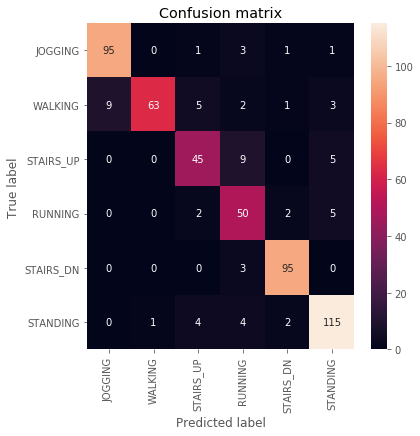

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       101
           1       0.98      0.76      0.86        83
           2       0.79      0.76      0.78        59
           3       0.70      0.85      0.77        59
           4       0.94      0.97      0.95        98
           5       0.89      0.91      0.90       126

    accuracy                           0.88       526
   macro avg       0.87      0.87      0.86       526
weighted avg       0.89      0.88      0.88       526


final results: accuracy: 0.8802281618118286 loss: 1.8193095922470093


---------------------------Run_model for window size : 80, step size : 40.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.3330792784690857
epoch: 1 test accuracy: 0.32826748490333557 loss: 3.0982208251953125 | train accuracy: 0.3330792784690857 loss :3.0956668853759766

Epoch: 2 acc:0.5022866129875183
Epoch: 3 acc:0.5975610017776489
Epoch: 4 acc:0.6509

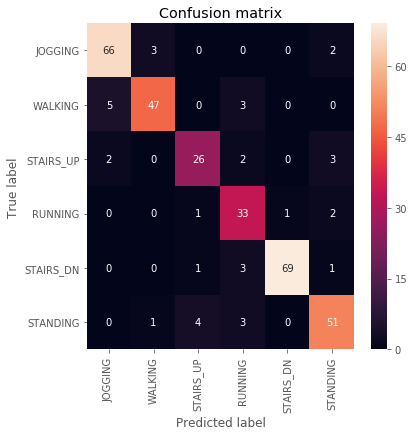

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        71
           1       0.92      0.85      0.89        55
           2       0.81      0.79      0.80        33
           3       0.75      0.89      0.81        37
           4       0.99      0.93      0.96        74
           5       0.86      0.86      0.86        59

    accuracy                           0.89       329
   macro avg       0.87      0.88      0.87       329
weighted avg       0.89      0.89      0.89       329


final results: accuracy: 0.8875380158424377 loss: 1.7858867645263672


---------------------------Run_model for window size : 120, step size : 60.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.1874285787343979
epoch: 1 test accuracy: 0.15981735289096832 loss: 3.629390239715576 | train accuracy: 0.1874285787343979 loss :3.5339207649230957

Epoch: 2 acc:0.4262857139110565
Epoch: 3 acc:0.3782857060432434
Epoch: 4 acc:0.5108

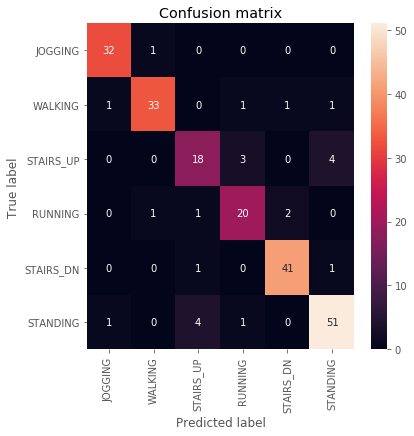

              precision    recall  f1-score   support

           0       0.94      0.97      0.96        33
           1       0.94      0.89      0.92        37
           2       0.75      0.72      0.73        25
           3       0.80      0.83      0.82        24
           4       0.93      0.95      0.94        43
           5       0.89      0.89      0.89        57

    accuracy                           0.89       219
   macro avg       0.88      0.88      0.88       219
weighted avg       0.89      0.89      0.89       219


final results: accuracy: 0.8904109597206116 loss: 1.7156473398208618


---------------------------Run_model for window size : 160, step size : 80.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.2073170691728592
epoch: 1 test accuracy: 0.18902438879013062 loss: 3.685413360595703 | train accuracy: 0.2073170691728592 loss :3.540496349334717

Epoch: 2 acc:0.26524388790130615
Epoch: 3 acc:0.3856707215309143
Epoch: 4 acc:0.4557

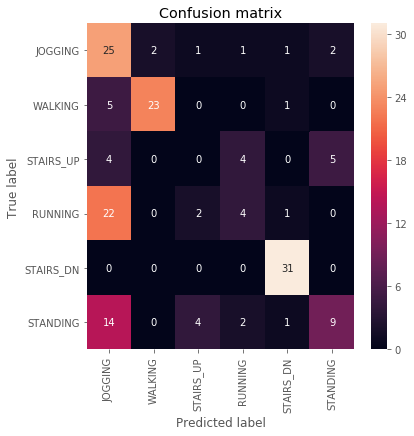

              precision    recall  f1-score   support

           0       0.36      0.78      0.49        32
           1       0.92      0.79      0.85        29
           2       0.00      0.00      0.00        13
           3       0.36      0.14      0.20        29
           4       0.89      1.00      0.94        31
           5       0.56      0.30      0.39        30

    accuracy                           0.56       164
   macro avg       0.51      0.50      0.48       164
weighted avg       0.57      0.56      0.53       164


final results: accuracy: 0.5609756112098694 loss: 2.619765281677246


---------------------------Run_model for window size : 200, step size : 100.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.21755725145339966
epoch: 1 test accuracy: 0.25 loss: 3.5326790809631348 | train accuracy: 0.21755725145339966 loss :3.598036766052246

Epoch: 2 acc:0.37404578924179077
Epoch: 3 acc:0.37595421075820923
Epoch: 4 acc:0.366412222385406

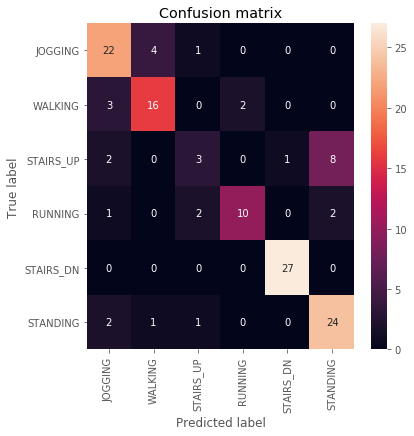

              precision    recall  f1-score   support

           0       0.73      0.81      0.77        27
           1       0.76      0.76      0.76        21
           2       0.43      0.21      0.29        14
           3       0.83      0.67      0.74        15
           4       0.96      1.00      0.98        27
           5       0.71      0.86      0.77        28

    accuracy                           0.77       132
   macro avg       0.74      0.72      0.72       132
weighted avg       0.76      0.77      0.76       132


final results: accuracy: 0.7727272510528564 loss: 2.072606086730957

---------- Model : 4 ---------------

learning_rate: 0.002415977827566457, batch_size: 229, hidden_units: 68, epochs: 15, l2_loss: 0.001667240515268304 


---------------------------Run_model for window size : 50, step size : 25.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.6092336773872375
epoch: 1 test accuracy: 0.6026616096496582 loss: 2.19394493103

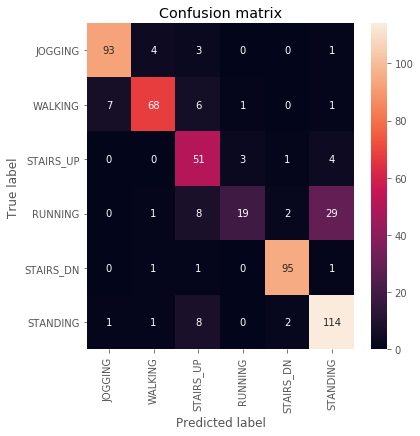

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       101
           1       0.91      0.82      0.86        83
           2       0.66      0.86      0.75        59
           3       0.83      0.32      0.46        59
           4       0.95      0.97      0.96        98
           5       0.76      0.90      0.83       126

    accuracy                           0.84       526
   macro avg       0.84      0.80      0.80       526
weighted avg       0.85      0.84      0.83       526


final results: accuracy: 0.8365018963813782 loss: 1.4863123893737793


---------------------------Run_model for window size : 80, step size : 40.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.45426830649375916
epoch: 1 test accuracy: 0.47416412830352783 loss: 2.5040249824523926 | train accuracy: 0.45426830649375916 loss :2.521890163421631

Epoch: 2 acc:0.5045731663703918
Epoch: 3 acc:0.5777438879013062
Epoch: 4 acc:0.657

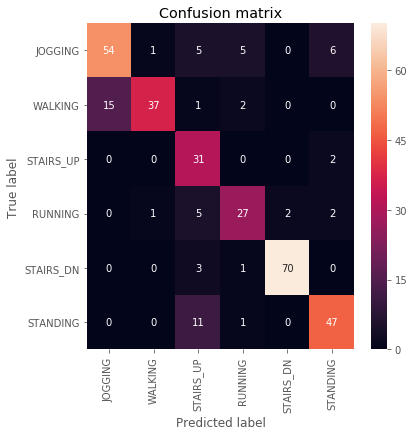

              precision    recall  f1-score   support

           0       0.78      0.76      0.77        71
           1       0.95      0.67      0.79        55
           2       0.55      0.94      0.70        33
           3       0.75      0.73      0.74        37
           4       0.97      0.95      0.96        74
           5       0.82      0.80      0.81        59

    accuracy                           0.81       329
   macro avg       0.81      0.81      0.79       329
weighted avg       0.83      0.81      0.81       329


final results: accuracy: 0.8085106611251831 loss: 1.5293102264404297


---------------------------Run_model for window size : 120, step size : 60.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.3782857060432434
epoch: 1 test accuracy: 0.39269405603408813 loss: 2.8923494815826416 | train accuracy: 0.3782857060432434 loss :2.8112730979919434

Epoch: 2 acc:0.508571445941925
Epoch: 3 acc:0.5885714292526245
Epoch: 4 acc:0.6228

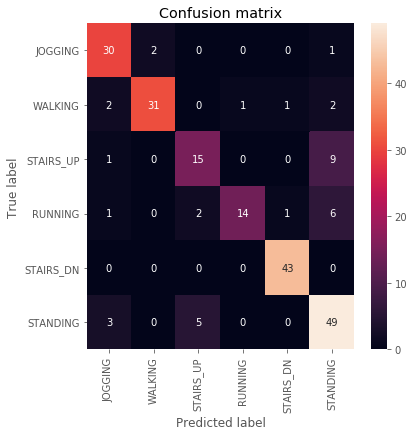

              precision    recall  f1-score   support

           0       0.81      0.91      0.86        33
           1       0.94      0.84      0.89        37
           2       0.68      0.60      0.64        25
           3       0.93      0.58      0.72        24
           4       0.96      1.00      0.98        43
           5       0.73      0.86      0.79        57

    accuracy                           0.83       219
   macro avg       0.84      0.80      0.81       219
weighted avg       0.84      0.83      0.83       219


final results: accuracy: 0.8310502171516418 loss: 1.582719326019287


---------------------------Run_model for window size : 160, step size : 80.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.33079269528388977
epoch: 1 test accuracy: 0.35975611209869385 loss: 3.2695765495300293 | train accuracy: 0.33079269528388977 loss :3.1980016231536865

Epoch: 2 acc:0.4466463327407837
Epoch: 3 acc:0.5365853905677795
Epoch: 4 acc:0.47

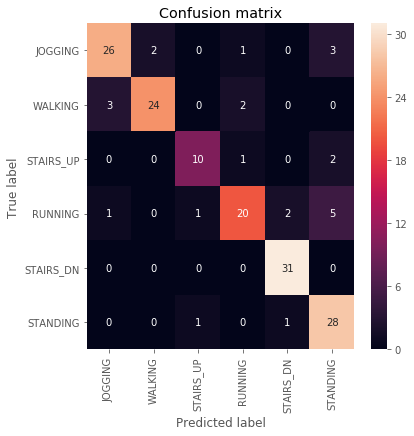

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        32
           1       0.92      0.83      0.87        29
           2       0.83      0.77      0.80        13
           3       0.83      0.69      0.75        29
           4       0.91      1.00      0.95        31
           5       0.74      0.93      0.82        30

    accuracy                           0.85       164
   macro avg       0.85      0.84      0.84       164
weighted avg       0.85      0.85      0.85       164


final results: accuracy: 0.8475610017776489 loss: 1.6858381032943726


---------------------------Run_model for window size : 200, step size : 100.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.3187022805213928
epoch: 1 test accuracy: 0.2954545319080353 loss: 2.9506726264953613 | train accuracy: 0.3187022805213928 loss :2.861572742462158

Epoch: 2 acc:0.42175573110580444
Epoch: 3 acc:0.5267175436019897
Epoch: 4 acc:0.599

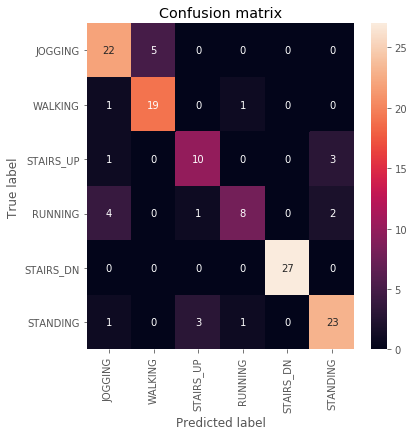

              precision    recall  f1-score   support

           0       0.76      0.81      0.79        27
           1       0.79      0.90      0.84        21
           2       0.71      0.71      0.71        14
           3       0.80      0.53      0.64        15
           4       1.00      1.00      1.00        27
           5       0.82      0.82      0.82        28

    accuracy                           0.83       132
   macro avg       0.81      0.80      0.80       132
weighted avg       0.83      0.83      0.82       132


final results: accuracy: 0.8257575631141663 loss: 1.5569212436676025

---------- Model : 5 ---------------

learning_rate: 0.0027111720819702986, batch_size: 62, hidden_units: 68, epochs: 10, l2_loss: 0.002477993485288549 


---------------------------Run_model for window size : 50, step size : 25.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.6972870230674744
epoch: 1 test accuracy: 0.7129277586936951 loss: 2.4053907394

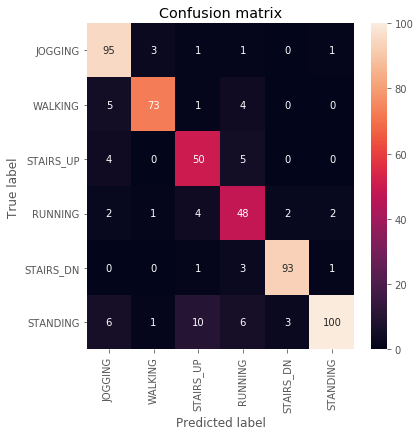

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       101
           1       0.94      0.88      0.91        83
           2       0.75      0.85      0.79        59
           3       0.72      0.81      0.76        59
           4       0.95      0.95      0.95        98
           5       0.96      0.79      0.87       126

    accuracy                           0.87       526
   macro avg       0.86      0.87      0.86       526
weighted avg       0.88      0.87      0.87       526


final results: accuracy: 0.8726235628128052 loss: 1.428468108177185


---------------------------Run_model for window size : 80, step size : 40.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.6425305008888245
epoch: 1 test accuracy: 0.6139817833900452 loss: 2.4892873764038086 | train accuracy: 0.6425305008888245 loss :2.4795351028442383

Epoch: 2 acc:0.6836889982223511
Epoch: 3 acc:0.75
Epoch: 4 acc:0.8048780560493469
Epo

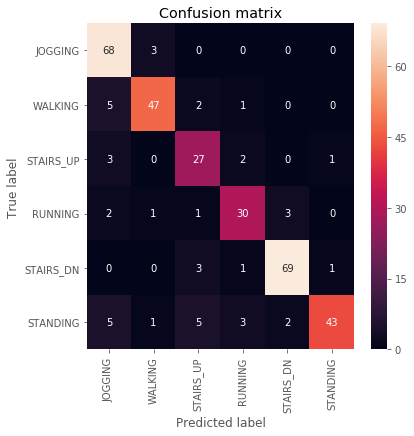

              precision    recall  f1-score   support

           0       0.82      0.96      0.88        71
           1       0.90      0.85      0.88        55
           2       0.71      0.82      0.76        33
           3       0.81      0.81      0.81        37
           4       0.93      0.93      0.93        74
           5       0.96      0.73      0.83        59

    accuracy                           0.86       329
   macro avg       0.86      0.85      0.85       329
weighted avg       0.87      0.86      0.86       329


final results: accuracy: 0.8632218837738037 loss: 1.4813238382339478


---------------------------Run_model for window size : 120, step size : 60.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.5062857270240784
epoch: 1 test accuracy: 0.49771690368652344 loss: 2.849062442779541 | train accuracy: 0.5062857270240784 loss :2.8353185653686523

Epoch: 2 acc:0.6628571152687073
Epoch: 3 acc:0.6514285802841187
Epoch: 4 acc:0.7360

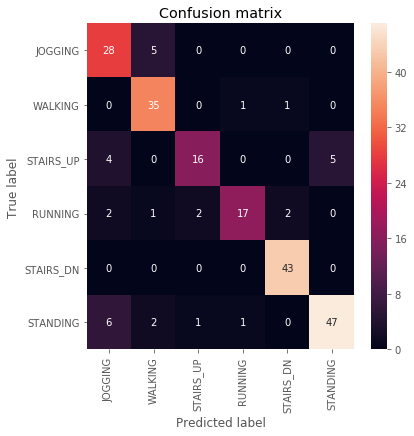

              precision    recall  f1-score   support

           0       0.70      0.85      0.77        33
           1       0.81      0.95      0.88        37
           2       0.84      0.64      0.73        25
           3       0.89      0.71      0.79        24
           4       0.93      1.00      0.97        43
           5       0.90      0.82      0.86        57

    accuracy                           0.85       219
   macro avg       0.85      0.83      0.83       219
weighted avg       0.86      0.85      0.85       219


final results: accuracy: 0.8493150472640991 loss: 1.8358521461486816


---------------------------Run_model for window size : 160, step size : 80.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.3643292784690857
epoch: 1 test accuracy: 0.34756097197532654 loss: 3.1748905181884766 | train accuracy: 0.3643292784690857 loss :3.1312918663024902

Epoch: 2 acc:0.6082317233085632
Epoch: 3 acc:0.6890243887901306
Epoch: 4 acc:0.667

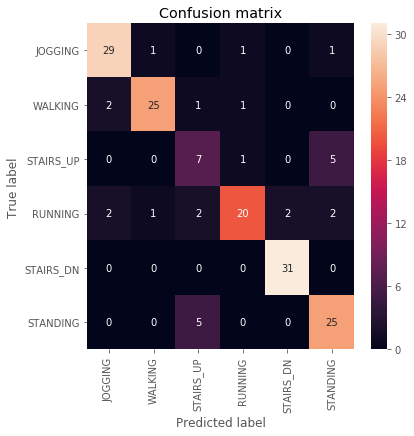

              precision    recall  f1-score   support

           0       0.88      0.91      0.89        32
           1       0.93      0.86      0.89        29
           2       0.47      0.54      0.50        13
           3       0.87      0.69      0.77        29
           4       0.94      1.00      0.97        31
           5       0.76      0.83      0.79        30

    accuracy                           0.84       164
   macro avg       0.81      0.80      0.80       164
weighted avg       0.84      0.84      0.84       164


final results: accuracy: 0.8353658318519592 loss: 1.7755706310272217


---------------------------Run_model for window size : 200, step size : 100.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.40839695930480957
epoch: 1 test accuracy: 0.39393940567970276 loss: 3.1790294647216797 | train accuracy: 0.40839695930480957 loss :3.1716418266296387

Epoch: 2 acc:0.5133587718009949
Epoch: 3 acc:0.7003816962242126
Epoch: 4 acc:0.

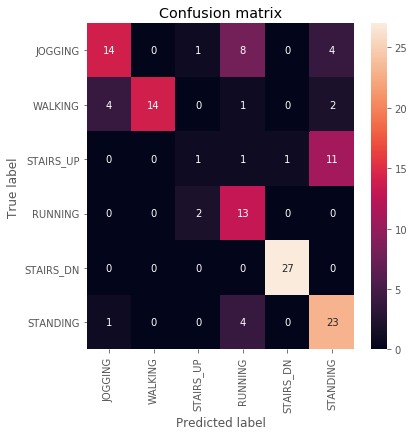

              precision    recall  f1-score   support

           0       0.74      0.52      0.61        27
           1       1.00      0.67      0.80        21
           2       0.25      0.07      0.11        14
           3       0.48      0.87      0.62        15
           4       0.96      1.00      0.98        27
           5       0.57      0.82      0.68        28

    accuracy                           0.70       132
   macro avg       0.67      0.66      0.63       132
weighted avg       0.71      0.70      0.68       132


final results: accuracy: 0.6969696879386902 loss: 2.329655170440674

---------- Model : 6 ---------------

learning_rate: 0.0024454697601615986, batch_size: 96, hidden_units: 66, epochs: 13, l2_loss: 0.0030693147746978177 


---------------------------Run_model for window size : 50, step size : 25.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.6330319046974182
epoch: 1 test accuracy: 0.6311787366867065 loss: 2.8193058967

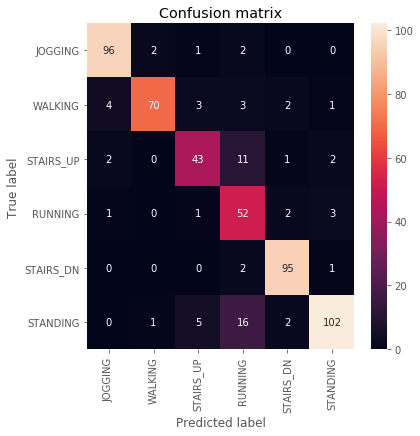

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       101
           1       0.96      0.84      0.90        83
           2       0.81      0.73      0.77        59
           3       0.60      0.88      0.72        59
           4       0.93      0.97      0.95        98
           5       0.94      0.81      0.87       126

    accuracy                           0.87       526
   macro avg       0.86      0.86      0.86       526
weighted avg       0.89      0.87      0.87       526


final results: accuracy: 0.8707224130630493 loss: 1.654561996459961


---------------------------Run_model for window size : 80, step size : 40.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.6013719439506531
epoch: 1 test accuracy: 0.5653495192527771 loss: 3.174504280090332 | train accuracy: 0.6013719439506531 loss :3.16829776763916

Epoch: 2 acc:0.6280487775802612
Epoch: 3 acc:0.6996951103210449
Epoch: 4 acc:0.774390220

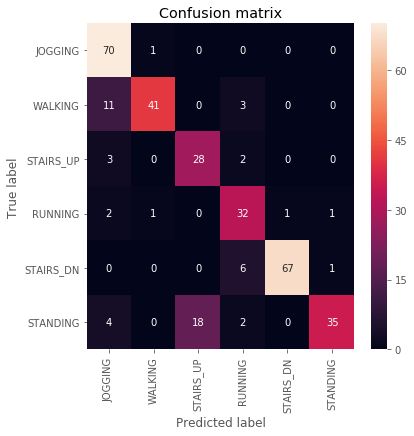

              precision    recall  f1-score   support

           0       0.78      0.99      0.87        71
           1       0.95      0.75      0.84        55
           2       0.61      0.85      0.71        33
           3       0.71      0.86      0.78        37
           4       0.99      0.91      0.94        74
           5       0.95      0.59      0.73        59

    accuracy                           0.83       329
   macro avg       0.83      0.82      0.81       329
weighted avg       0.86      0.83      0.83       329


final results: accuracy: 0.8297872543334961 loss: 1.979121208190918


---------------------------Run_model for window size : 120, step size : 60.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.4502857029438019
epoch: 1 test accuracy: 0.5159817337989807 loss: 3.178978443145752 | train accuracy: 0.4502857029438019 loss :3.242619752883911

Epoch: 2 acc:0.5131428837776184
Epoch: 3 acc:0.5805714130401611
Epoch: 4 acc:0.7531428

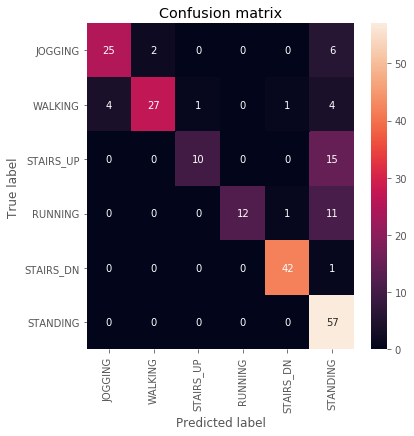

              precision    recall  f1-score   support

           0       0.86      0.76      0.81        33
           1       0.93      0.73      0.82        37
           2       0.91      0.40      0.56        25
           3       1.00      0.50      0.67        24
           4       0.95      0.98      0.97        43
           5       0.61      1.00      0.75        57

    accuracy                           0.79       219
   macro avg       0.88      0.73      0.76       219
weighted avg       0.85      0.79      0.78       219


final results: accuracy: 0.7899543642997742 loss: 2.15226149559021


---------------------------Run_model for window size : 160, step size : 80.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.4451219439506531
epoch: 1 test accuracy: 0.4451219439506531 loss: 3.3118536472320557 | train accuracy: 0.4451219439506531 loss :3.393958568572998

Epoch: 2 acc:0.48475611209869385
Epoch: 3 acc:0.6173780560493469
Epoch: 4 acc:0.724085

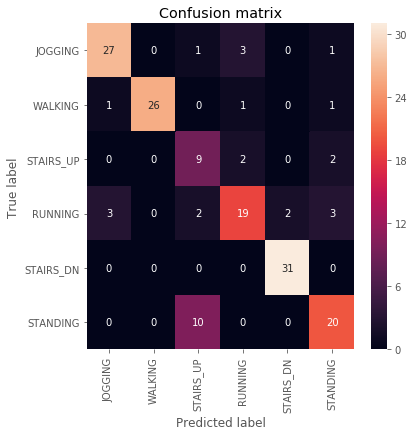

              precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       1.00      0.90      0.95        29
           2       0.41      0.69      0.51        13
           3       0.76      0.66      0.70        29
           4       0.94      1.00      0.97        31
           5       0.74      0.67      0.70        30

    accuracy                           0.80       164
   macro avg       0.79      0.79      0.78       164
weighted avg       0.83      0.80      0.81       164


final results: accuracy: 0.8048780560493469 loss: 2.147826910018921


---------------------------Run_model for window size : 200, step size : 100.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.4522900879383087
epoch: 1 test accuracy: 0.4469696879386902 loss: 3.4667444229125977 | train accuracy: 0.4522900879383087 loss :3.4798922538757324

Epoch: 2 acc:0.5057252049446106
Epoch: 3 acc:0.635496199131012
Epoch: 4 acc:0.61450

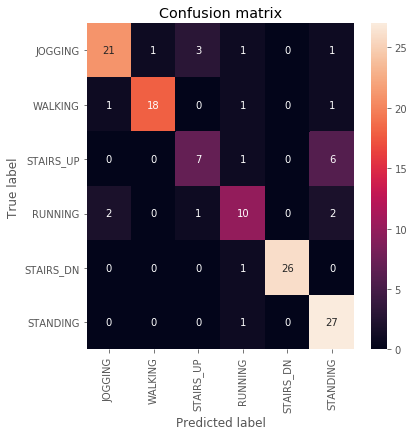

              precision    recall  f1-score   support

           0       0.88      0.78      0.82        27
           1       0.95      0.86      0.90        21
           2       0.64      0.50      0.56        14
           3       0.67      0.67      0.67        15
           4       1.00      0.96      0.98        27
           5       0.73      0.96      0.83        28

    accuracy                           0.83       132
   macro avg       0.81      0.79      0.79       132
weighted avg       0.83      0.83      0.82       132


final results: accuracy: 0.8257575631141663 loss: 2.294980049133301

---------- Model : 7 ---------------

learning_rate: 0.0019989839765513313, batch_size: 149, hidden_units: 70, epochs: 23, l2_loss: 0.001821717540232049 


---------------------------Run_model for window size : 50, step size : 25.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.5821037888526917
epoch: 1 test accuracy: 0.5418251156806946 loss: 2.3801016807

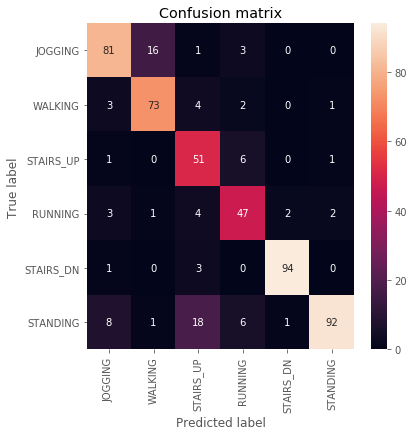

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       101
           1       0.80      0.88      0.84        83
           2       0.63      0.86      0.73        59
           3       0.73      0.80      0.76        59
           4       0.97      0.96      0.96        98
           5       0.96      0.73      0.83       126

    accuracy                           0.83       526
   macro avg       0.82      0.84      0.82       526
weighted avg       0.85      0.83      0.84       526


final results: accuracy: 0.8326995968818665 loss: 1.6120998859405518


---------------------------Run_model for window size : 80, step size : 40.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.41158536076545715
epoch: 1 test accuracy: 0.4164133667945862 loss: 2.8492493629455566 | train accuracy: 0.41158536076545715 loss :2.8573381900787354

Epoch: 2 acc:0.5045731663703918
Epoch: 3 acc:0.6524389982223511
Epoch: 4 acc:0.702

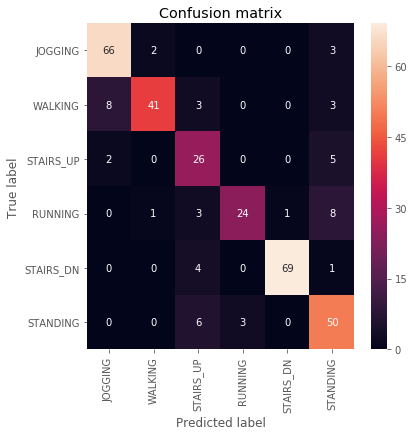

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        71
           1       0.93      0.75      0.83        55
           2       0.62      0.79      0.69        33
           3       0.89      0.65      0.75        37
           4       0.99      0.93      0.96        74
           5       0.71      0.85      0.78        59

    accuracy                           0.84       329
   macro avg       0.83      0.82      0.82       329
weighted avg       0.86      0.84      0.84       329


final results: accuracy: 0.8389057517051697 loss: 1.6017179489135742


---------------------------Run_model for window size : 120, step size : 60.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.30628570914268494
epoch: 1 test accuracy: 0.2511415481567383 loss: 2.907066822052002 | train accuracy: 0.30628570914268494 loss :2.8409392833709717

Epoch: 2 acc:0.43314287066459656
Epoch: 3 acc:0.6000000238418579
Epoch: 4 acc:0.69

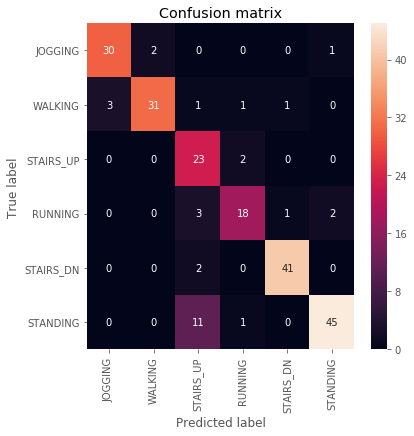

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        33
           1       0.94      0.84      0.89        37
           2       0.57      0.92      0.71        25
           3       0.82      0.75      0.78        24
           4       0.95      0.95      0.95        43
           5       0.94      0.79      0.86        57

    accuracy                           0.86       219
   macro avg       0.86      0.86      0.85       219
weighted avg       0.88      0.86      0.86       219


final results: accuracy: 0.8584474921226501 loss: 1.5435901880264282


---------------------------Run_model for window size : 160, step size : 80.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.3871951103210449
epoch: 1 test accuracy: 0.42073169350624084 loss: 3.029176712036133 | train accuracy: 0.3871951103210449 loss :3.2817814350128174

Epoch: 2 acc:0.5243902206420898
Epoch: 3 acc:0.5533536672592163
Epoch: 4 acc:0.6097

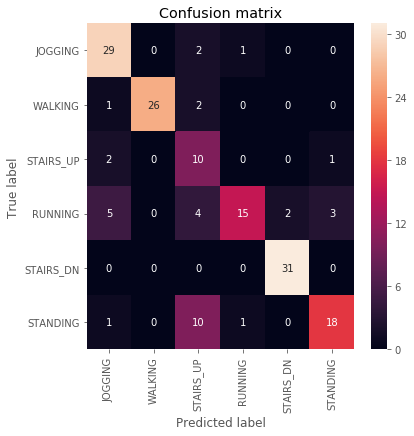

              precision    recall  f1-score   support

           0       0.76      0.91      0.83        32
           1       1.00      0.90      0.95        29
           2       0.36      0.77      0.49        13
           3       0.88      0.52      0.65        29
           4       0.94      1.00      0.97        31
           5       0.82      0.60      0.69        30

    accuracy                           0.79       164
   macro avg       0.79      0.78      0.76       164
weighted avg       0.84      0.79      0.79       164


final results: accuracy: 0.7865853905677795 loss: 1.809560775756836


---------------------------Run_model for window size : 200, step size : 100.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.29389312863349915
epoch: 1 test accuracy: 0.3030303120613098 loss: 3.211254119873047 | train accuracy: 0.29389312863349915 loss :3.197476625442505

Epoch: 2 acc:0.39694657921791077
Epoch: 3 acc:0.5400763154029846
Epoch: 4 acc:0.562

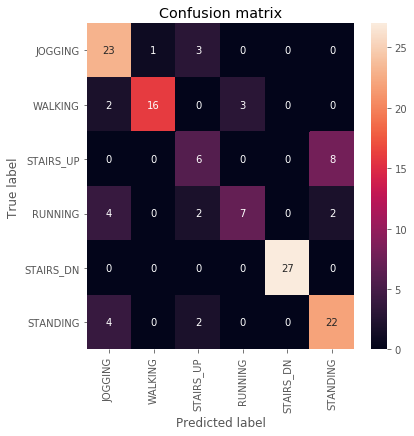

              precision    recall  f1-score   support

           0       0.70      0.85      0.77        27
           1       0.94      0.76      0.84        21
           2       0.46      0.43      0.44        14
           3       0.70      0.47      0.56        15
           4       1.00      1.00      1.00        27
           5       0.69      0.79      0.73        28

    accuracy                           0.77       132
   macro avg       0.75      0.72      0.72       132
weighted avg       0.77      0.77      0.76       132


final results: accuracy: 0.7651515007019043 loss: 1.819258451461792

---------- Model : 8 ---------------

learning_rate: 0.0023081959278958707, batch_size: 198, hidden_units: 65, epochs: 13, l2_loss: 0.0036509830844932037 


---------------------------Run_model for window size : 50, step size : 25.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.6106615662574768
epoch: 1 test accuracy: 0.6330798268318176 loss: 3.363764762

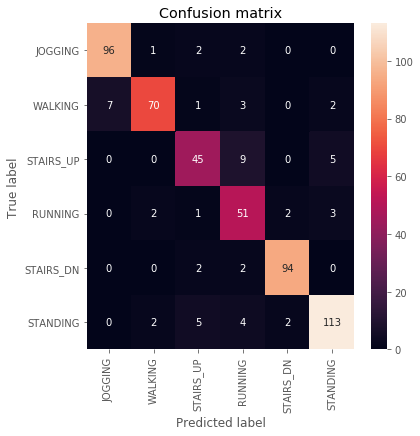

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       101
           1       0.93      0.84      0.89        83
           2       0.80      0.76      0.78        59
           3       0.72      0.86      0.78        59
           4       0.96      0.96      0.96        98
           5       0.92      0.90      0.91       126

    accuracy                           0.89       526
   macro avg       0.88      0.88      0.88       526
weighted avg       0.90      0.89      0.89       526


final results: accuracy: 0.891635000705719 loss: 2.1279804706573486


---------------------------Run_model for window size : 80, step size : 40.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.45121949911117554
epoch: 1 test accuracy: 0.4772036373615265 loss: 3.5217678546905518 | train accuracy: 0.45121949911117554 loss :3.5451464653015137

Epoch: 2 acc:0.5434451103210449
Epoch: 3 acc:0.6791158318519592
Epoch: 4 acc:0.7294

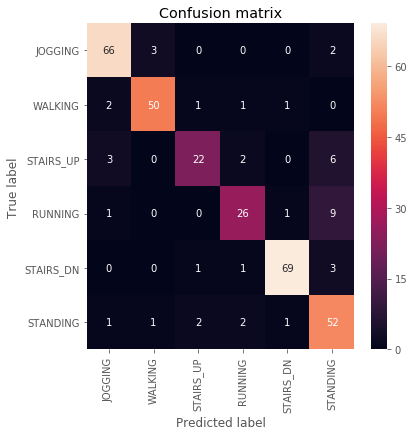

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        71
           1       0.93      0.91      0.92        55
           2       0.85      0.67      0.75        33
           3       0.81      0.70      0.75        37
           4       0.96      0.93      0.95        74
           5       0.72      0.88      0.79        59

    accuracy                           0.87       329
   macro avg       0.86      0.84      0.85       329
weighted avg       0.87      0.87      0.87       329


final results: accuracy: 0.8662614226341248 loss: 2.207423448562622


---------------------------Run_model for window size : 120, step size : 60.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.25028571486473083
epoch: 1 test accuracy: 0.30136987566947937 loss: 3.9542534351348877 | train accuracy: 0.25028571486473083 loss :3.96875

Epoch: 2 acc:0.3782857060432434
Epoch: 3 acc:0.5417143106460571
Epoch: 4 acc:0.5691428780555

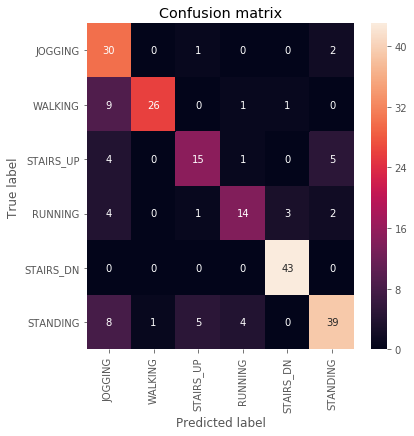

              precision    recall  f1-score   support

           0       0.55      0.91      0.68        33
           1       0.96      0.70      0.81        37
           2       0.68      0.60      0.64        25
           3       0.70      0.58      0.64        24
           4       0.91      1.00      0.96        43
           5       0.81      0.68      0.74        57

    accuracy                           0.76       219
   macro avg       0.77      0.75      0.74       219
weighted avg       0.79      0.76      0.76       219


final results: accuracy: 0.7625570893287659 loss: 2.5732946395874023


---------------------------Run_model for window size : 160, step size : 80.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.35060974955558777
epoch: 1 test accuracy: 0.37804877758026123 loss: 4.3037214279174805 | train accuracy: 0.35060974955558777 loss :4.421947479248047

Epoch: 2 acc:0.32621949911117554
Epoch: 3 acc:0.4710365831851959
Epoch: 4 acc:0.5

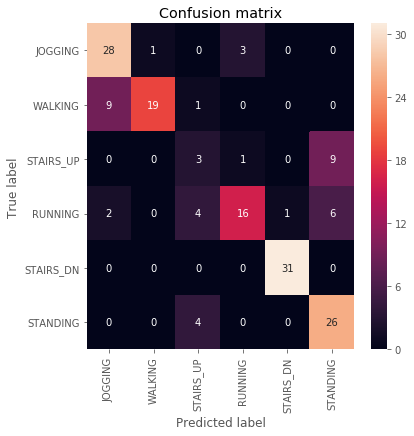

              precision    recall  f1-score   support

           0       0.72      0.88      0.79        32
           1       0.95      0.66      0.78        29
           2       0.25      0.23      0.24        13
           3       0.80      0.55      0.65        29
           4       0.97      1.00      0.98        31
           5       0.63      0.87      0.73        30

    accuracy                           0.75       164
   macro avg       0.72      0.70      0.70       164
weighted avg       0.77      0.75      0.75       164


final results: accuracy: 0.75 loss: 2.7465271949768066


---------------------------Run_model for window size : 200, step size : 100.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.37977099418640137
epoch: 1 test accuracy: 0.3712121248245239 loss: 3.900836706161499 | train accuracy: 0.37977099418640137 loss :3.924903392791748

Epoch: 2 acc:0.5038167834281921
Epoch: 3 acc:0.48473283648490906
Epoch: 4 acc:0.5248091816902161

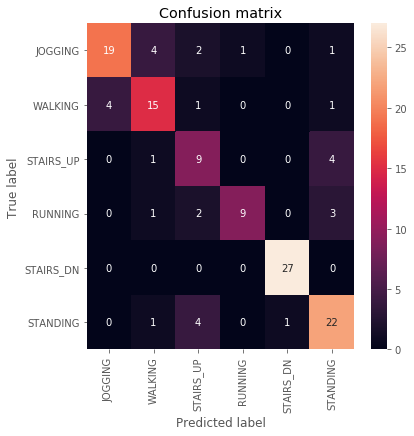

              precision    recall  f1-score   support

           0       0.83      0.70      0.76        27
           1       0.68      0.71      0.70        21
           2       0.50      0.64      0.56        14
           3       0.90      0.60      0.72        15
           4       0.96      1.00      0.98        27
           5       0.71      0.79      0.75        28

    accuracy                           0.77       132
   macro avg       0.76      0.74      0.74       132
weighted avg       0.78      0.77      0.77       132


final results: accuracy: 0.7651515007019043 loss: 2.6532833576202393

---------- Model : 9 ---------------

learning_rate: 0.001097520487873353, batch_size: 443, hidden_units: 67, epochs: 35, l2_loss: 0.0017672472638444266 


---------------------------Run_model for window size : 50, step size : 25.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.38124701380729675
epoch: 1 test accuracy: 0.3403041958808899 loss: 2.78635120

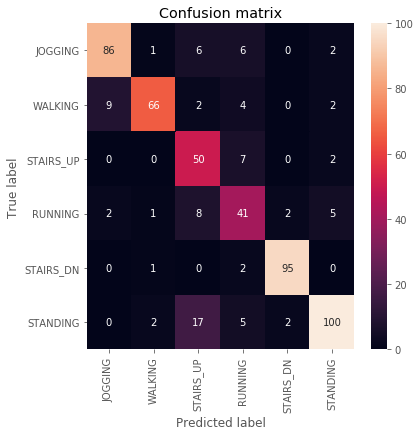

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       101
           1       0.93      0.80      0.86        83
           2       0.60      0.85      0.70        59
           3       0.63      0.69      0.66        59
           4       0.96      0.97      0.96        98
           5       0.90      0.79      0.84       126

    accuracy                           0.83       526
   macro avg       0.82      0.83      0.82       526
weighted avg       0.85      0.83      0.84       526


final results: accuracy: 0.8326995968818665 loss: 1.6905211210250854


---------------------------Run_model for window size : 80, step size : 40.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.37957316637039185
epoch: 1 test accuracy: 0.3951367735862732 loss: 2.8519463539123535 | train accuracy: 0.37957316637039185 loss :2.9079360961914062

Epoch: 2 acc:0.4489329159259796
Epoch: 3 acc:0.45045730471611023
Epoch: 4 acc:0.56

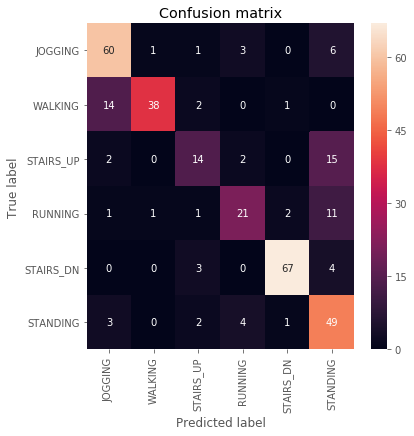

              precision    recall  f1-score   support

           0       0.75      0.85      0.79        71
           1       0.95      0.69      0.80        55
           2       0.61      0.42      0.50        33
           3       0.70      0.57      0.63        37
           4       0.94      0.91      0.92        74
           5       0.58      0.83      0.68        59

    accuracy                           0.76       329
   macro avg       0.75      0.71      0.72       329
weighted avg       0.78      0.76      0.76       329


final results: accuracy: 0.7568389177322388 loss: 1.8629285097122192


---------------------------Run_model for window size : 120, step size : 60.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.28457143902778625
epoch: 1 test accuracy: 0.2876712381839752 loss: 2.952075719833374 | train accuracy: 0.28457143902778625 loss :2.928096055984497

Epoch: 2 acc:0.39885714650154114
Epoch: 3 acc:0.42971429228782654
Epoch: 4 acc:0.49

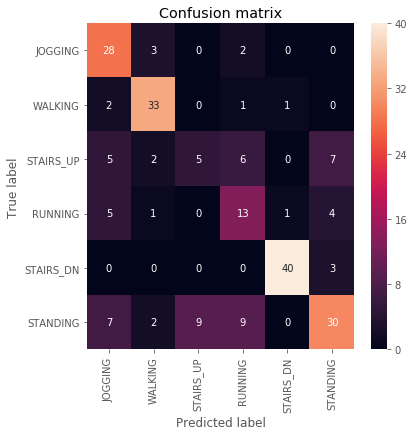

              precision    recall  f1-score   support

           0       0.60      0.85      0.70        33
           1       0.80      0.89      0.85        37
           2       0.36      0.20      0.26        25
           3       0.42      0.54      0.47        24
           4       0.95      0.93      0.94        43
           5       0.68      0.53      0.59        57

    accuracy                           0.68       219
   macro avg       0.64      0.66      0.64       219
weighted avg       0.68      0.68      0.67       219


final results: accuracy: 0.6803653240203857 loss: 2.0571298599243164


---------------------------Run_model for window size : 160, step size : 80.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.14024390280246735
epoch: 1 test accuracy: 0.18902438879013062 loss: 3.4065098762512207 | train accuracy: 0.14024390280246735 loss :3.5423502922058105

Epoch: 2 acc:0.19664634764194489
Epoch: 3 acc:0.30640244483947754
Epoch: 4 acc:0

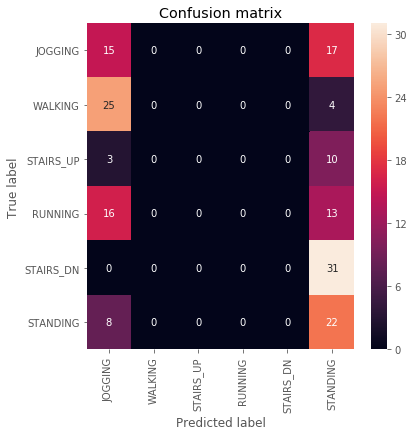

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.22      0.47      0.30        32
           1       0.00      0.00      0.00        29
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00        31
           5       0.23      0.73      0.35        30

    accuracy                           0.23       164
   macro avg       0.08      0.20      0.11       164
weighted avg       0.09      0.23      0.12       164


final results: accuracy: 0.22560974955558777 loss: 2.9461584091186523


---------------------------Run_model for window size : 200, step size : 100.0------------------

Creating Segments ... 
Building Modal ... 
Epoch: 1 acc:0.25190839171409607
epoch: 1 test accuracy: 0.27272728085517883 loss: 3.2416348457336426 | train accuracy: 0.25190839171409607 loss :3.3790597915649414

Epoch: 2 acc:0.3320610821247101
Epoch: 3 acc:0.3721373975276947
Epoch: 4 acc:0

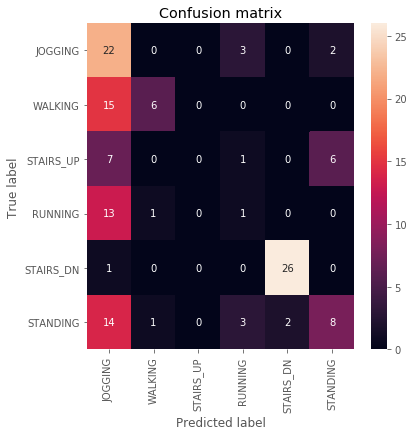

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.31      0.81      0.44        27
           1       0.75      0.29      0.41        21
           2       0.00      0.00      0.00        14
           3       0.12      0.07      0.09        15
           4       0.93      0.96      0.95        27
           5       0.50      0.29      0.36        28

    accuracy                           0.48       132
   macro avg       0.43      0.40      0.38       132
weighted avg       0.49      0.48      0.44       132


final results: accuracy: 0.47727271914482117 loss: 2.416646718978882



In [7]:
#----------------------------- Hyper Parameter Tuning -------------------------------------------
# summary = [run_model(window,BATCH_SIZE, LEARNING_RATE,N_EPOCHS, N_HIDDEN_UNITS,L2_LOSS, "epochs_hu", 2) for window in window_list]

# Random Initial Parameters
LEARNING_RATE =  0.001527643691277451
BATCH_SIZE =  326
N_HIDDEN_UNITS =  63
N_EPOCHS =  10
L2_LOSS =  0.0031853637328882623

# The number of steps within one time segment (window)
window_list  = [50, 80, 120, 160, 200]
# window_list  = [50, 75]
# The steps to take from one segment to the next; if this value is 50% of window size

for i in range(10): # random search hyper-parameter space 10 times for best epochs and hidden units with fixed lr and bs

    print("==============================================================================================")
    learning_rate, batch_size, hidden_units, epochs , l2_loss= generate_random_hyperparams(3, 1, 50, 500, 60, 80, 10, 50,5,1) 
    
    params = {'batch_size' : batch_size, 
                   'learning_rate' : learning_rate, 
                   'epochs' : epochs,
                   'hidden_units' : hidden_units,
                   'l2_loss' : l2_loss }
    
    print(f'---------- Model : {str(i)} ---------------')    
    print(f'\nlearning_rate: {learning_rate}, batch_size: {batch_size}, hidden_units: {hidden_units}, epochs: {epochs}, l2_loss: {l2_loss} \n')    
    
    summary = [run_model(window,batch_size, learning_rate,epochs, hidden_units,l2_loss, "epochs_hu", 2, False) for window in window_list]    
    performance_records[i] = {'params' : params, 'summary' : summary}


In [41]:
score = [{'params': performance_records[i]['params'] , 'score' : [ob['score'] for ob in performance_records[i]['summary']], 
      'history': [ob['history'] for ob in performance_records[i]['summary']], 
      'true_labels': [ob['true_labels'] for ob in performance_records[i]['summary']],
      'predictions': [ob['predictions'] for ob in performance_records[i]['summary']] } for i in performance_records]

DUMP_DIR = "pickle/"
print("Dumping Performance records ..")
pickle.dump(score, open(DUMP_DIR + "score.p", "wb"))
# pickle.dump(history, open(DUMP_DIR + "history.p", "wb"))


Dumping Performance records ..


In [42]:
data = pickle.load(open("pickle/score.p", 'rb'))
print(type(data))

<class 'list'>


In [43]:

#------------------------------------Exporting the model------------------------------------
# Storing model to disk
DUMP_DIR = LOGS_DIR + "/checkpoint/"

if not os.path.exists(DUMP_DIR):
    os.makedirs(DUMP_DIR)

print("Dumping predictions and history ..")
pickle.dump(predictions, open(DUMP_DIR + "predictions.p", "wb"))
pickle.dump(history, open(DUMP_DIR + "history.p", "wb"))

print("Wrtiting graph : har.pbtxt ..")
tf.train.write_graph(sess.graph_def, '.', DUMP_DIR + 'har.pbtxt')  

print("Saving checkpoint and closing session ..")
saver.save(sess, save_path = DUMP_DIR + "har.ckpt")
sess.close()

print("Load checkpoints and freeze graph for later use ..")

from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'
input_graph_path =  DUMP_DIR +  MODEL_NAME +'.pbtxt'
checkpoint_path =  DUMP_DIR + MODEL_NAME + '.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph =DUMP_DIR + MODEL_NAME +'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph, clear_devices=True, initializer_nodes="")


Dumping predictions and history ..


NameError: ignored

In [0]:
#------------------------------------ Validate Tensors ------------------------------------
# =============================================================================
# print("Load frozen graph and print tensors ..\n")
# def load_graph(frozen_graph_filename):
#     # We load the protobuf file from the disk and parse it to retrieve the 
#     # unserialized graph_def
#     with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
#         graph_def = tf.GraphDef()
#         graph_def.ParseFromString(f.read())
# 
#     # Then, we import the graph_def into a new Graph and return it 
#     with tf.Graph().as_default() as graph:
#         # The name var will prefix every op/nodes in your graph
#         # Since we load everything in a new graph, this is not needed
#         tf.import_graph_def(graph_def, name="prefix")
#     return graph
# 
# graph = load_graph(output_frozen_graph)
# 
# for op in graph.get_operations(): 
#         if "y_" in op.name or "input" in op.name:
#             print(op.name, " : " ,op.values())
# =============================================================================